## Analyse des Datensatzes: Dokumenten-Korpus, Queries und Jeweilige Relevanten Dokumente

Diese Analyse ist um den Korpus besser zu verstehen.
Es werden Statistiken auf Corpus-Ebene (Dokumentenlängen etc.) und auf Text-Ebene (Häufige Wörter etc.) berechnet.

<!--Die erhaltenen Informationen sind nützlich für das Pre-Processing der Texte (Zahlenwerte, Sonderzeichen, Textlängen, Abkürzungen, usw.) -->

<details>
<summary> Overview of analysis </summary>

Dataset size:
- Total number of documents
- Total number of queries
- Number of relevant documents per query (from qrels)


Document statistics:
- Average length of documents (in words or tokens)
- Distribution of document lengths
- Percentage of documents with only titles vs. those with both title and abstract
- Average length of titles and abstracts separately
- Sentence length distribution
- Part-of-speech distribution
- TF-IDF analysis to identify important terms
- Named Entity Recognition to understand the types of entities in your documents

Query statistics:
- Average length of queries (in words or tokens)
- Distribution of query lengths
- Types of questions (e.g., factoid, open-ended, etc.)
- Query complexity based on noun phrases and named entities
- Query type classification
- Word frequency analysis
- Query similarity analysis


Vocabulary statistics:
- Size of vocabulary (unique words) in the entire dataset
- Vocabulary overlap between queries and documents
- Detailed vocabulary size and overlap between documents and queries
- Word frequency distributions
- Comparison of top words in documents and queries
- Unique words in queries not found in documents
- TF-IDF analysis to identify important terms
- Lexical diversity measures



Domain-specific information:
- Most common topics or keywords in the dataset
- Distribution of publication years (if available)
- Distribution of venues or conferences (if available)
- Identification of potential domain-specific terms
- Word cloud visualization of domain-specific terms
- N-gram analysis (bigrams and trigrams)
- Document structure analysis (title length, presence of abstract)
- Common abbreviations in documents and queries
- Query type classification and distribution


Relevance judgments:
- Average number of relevant documents per query
- Distribution of relevance scores (if using graded relevance)
- Distribution of relevance scores
- Queries with most/least relevant documents
- Correlation between query length and number of relevant documents
- Percentage of queries with at least one relevant document
- Average relevance score


Data quality:
- Presence of any non-English documents or queries
- Presence of any duplicate documents or queries
- Any formatting inconsistencies or errors


For dense retrieval using FAISS + BERT-like model:
- Token limit: Check if any documents or queries exceed the max token limit of your chosen BERT-like model.
- Preprocessing: Determine if you need any specific preprocessing steps for scientific text (e.g., handling citations, equations, or special characters).
- Domain adaptation: Consider if you need to fine-tune your BERT-like model on scientific text for better performance.
- Embedding strategy: Decide how you'll handle documents with only titles vs. those with both title and abstract (e.g., separate embeddings or combined).
- Query-document similarity: Analyze the semantic similarity between queries and their relevant documents to gauge the potential effectiveness of dense retrieval.
- Out-of-vocabulary words: Check for domain-specific terms that might not be in your model's vocabulary.
</details>

#### Setup

In [2]:
#!pip install matplotlib
#!pip install nltk
#!pip install python-terrier

In [25]:
import os
import re
import json
from collections import Counter
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.precision", 4)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.5f}'.format)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import pyterrier as pt
from tira.third_party_integrations import ensure_pyterrier_is_loaded
from tira.third_party_integrations import ir_datasets
from tira.rest_api_client import Client
ensure_pyterrier_is_loaded()
tira = Client()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Dataset

In [14]:
dataset = pt.get_dataset('irds:ir-lab-sose-2024/ir-acl-anthology-20240504-training')
#docs = dataset.get_corpus()  # only get_corpus_iter() is possible -> docs loaded from ir_datasets
queries = dataset.get_topics()
qrels = dataset.get_qrels()

if os.path.exists("dataset_corpus.json"):
    with open("dataset_corpus.json", "r") as f:
        corpus = json.load(f)
else:
    ir_dataset = ir_datasets.load("ir-lab-sose-2024/ir-acl-anthology-20240504-training")
    corpus = ir_dataset.docs_store().docs
    del ir_dataset

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


In [15]:
corpus = [{"docno": v[0], "text": v[1]} for v in corpus.values()]
docs_df = pd.DataFrame(corpus)
queries_df = pd.DataFrame(queries)
qrels_df = pd.DataFrame(qrels)

print(f"# docs: {len(docs_df)}")
print(f"# queries: {len(queries_df)}")
print(f"# relevance judgements: {len(qrels_df)}")

# docs: 126958
# queries: 68
# relevance judgements: 2623


In [19]:
print(list(docs_df.columns))
print(list(queries_df.columns))
print(list(qrels_df.columns))

['docno', 'text']
['qid', 'text', 'title', 'query', 'description', 'narrative', 'query_length']
['qid', 'docno', 'label', 'iteration']


#### Document Statistics

Average document length: 102.62 words
Percentage of documents with abstract: 68.73%


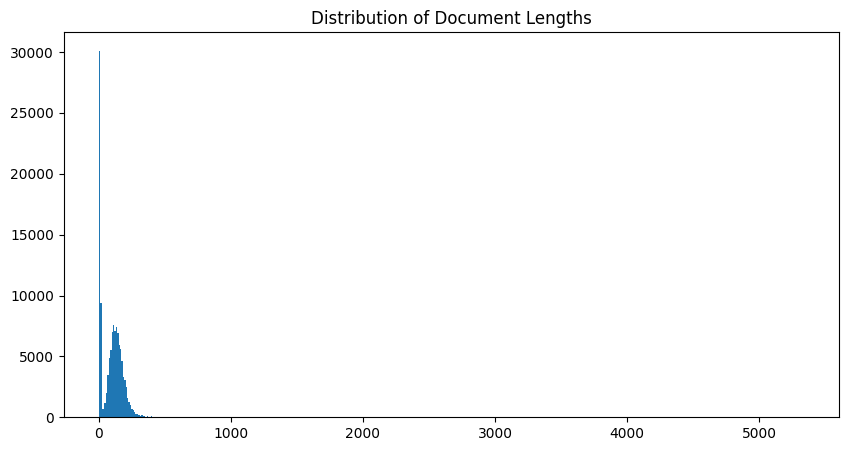

In [17]:
docs_df['doc_length'] = docs_df['text'].apply(lambda x: len(x.split()))
docs_df['has_abstract'] = docs_df['text'].apply(lambda x: '\n\n' in x)

print(f"Average document length: {docs_df['doc_length'].mean():.2f} words")
print(f"Percentage of documents with abstract: {docs_df['has_abstract'].mean()*100:.2f}%")

plt.figure(figsize=(10, 5))
plt.hist(docs_df['doc_length'], bins=500)
plt.title('Distribution of Document Lengths')
#plt.xlabel('Number of Words')
#plt.ylabel('Frequency')
plt.show()

In [18]:
# Seperate statistics for title and abstract
def preprocess_doc(text):
    parts = text.split('\n\n')
    title = parts[0]
    abstract = parts[1] if len(parts) > 1 else ""
    return title, abstract

docs_df['title'], docs_df['abstract'] = zip(*docs_df['text'].apply(preprocess_doc))

print(f"Average title length: {docs_df['title'].apply(len).mean():.2f} characters")
print(f"Average abstract length: {docs_df['abstract'].apply(len).mean():.2f} characters")

Average title length: 72.29 characters
Average abstract length: 631.04 characters


Average sentence length: 22.55 words


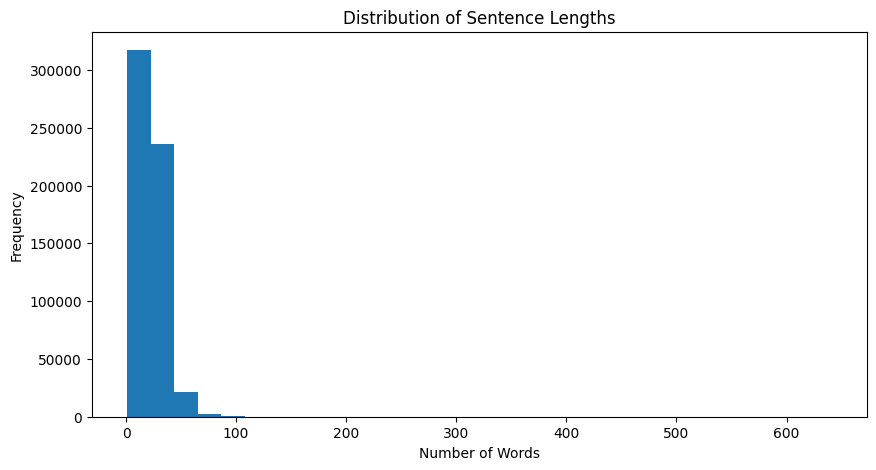

In [19]:
# Sentence length distribution
docs_df['sentences'] = docs_df['text'].apply(nltk.sent_tokenize)
docs_df['sentence_lengths'] = docs_df['sentences'].apply(lambda x: [len(s.split()) for s in x])

avg_sentence_length = np.mean([length for lengths in docs_df['sentence_lengths'] for length in lengths])
print(f"Average sentence length: {avg_sentence_length:.2f} words")

plt.figure(figsize=(10, 5))
plt.hist([length for lengths in docs_df['sentence_lengths'] for length in lengths], bins=30)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [1]:
# Part-of-speech distribution
nltk.download('averaged_perceptron_tagger')

def get_pos_tags(text):
    words = nltk.word_tokenize(text)
    return [tag for _, tag in nltk.pos_tag(words)]

docs_df['pos_tags'] = docs_df['text'].apply(get_pos_tags)
pos_counts = Counter([tag for tags in docs_df['pos_tags'] for tag in tags])

plt.figure(figsize=(12, 6))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.title('Distribution of Part-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [25]:
# TF-IDF analysis
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=1000)
tfidf_matrix = vectorizer.fit_transform(docs_df['text'])

feature_names = vectorizer.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
top_tfidf_words = sorted(zip(feature_names, tfidf_sums), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 words by TF-IDF score:")
for word, score in top_tfidf_words:
    print(f"{word}: {score:.4f}")

Top 20 words by TF-IDF score:
information: 4043.3388
based: 3871.8306
language: 3713.0696
data: 3498.0407
model: 3385.6392
system: 3356.0732
translation: 3057.8360
retrieval: 2981.7503
using: 2970.0846
task: 2868.4674
text: 2717.7618
models: 2608.8632
learning: 2474.6869
paper: 2438.3234
approach: 2430.2326
search: 2402.3531
web: 2385.8454
word: 2336.1644
semantic: 2225.2787
results: 2168.7621


In [7]:
# Named Entity Recognition
nltk.download('maxent_ne_chunker')
nltk.download('words')

def get_named_entities(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    return nltk.ne_chunk(pos_tags)

docs_df['named_entities'] = docs_df['text'].apply(get_named_entities)
entity_types = Counter([ne.label() for doc_ne in docs_df['named_entities'] for ne in doc_ne if isinstance(ne, nltk.Tree)])

plt.figure(figsize=(10, 5))
plt.bar(entity_types.keys(), entity_types.values())
plt.title('Distribution of Named Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


#### Query Statistics

Average query length: 9.93 words


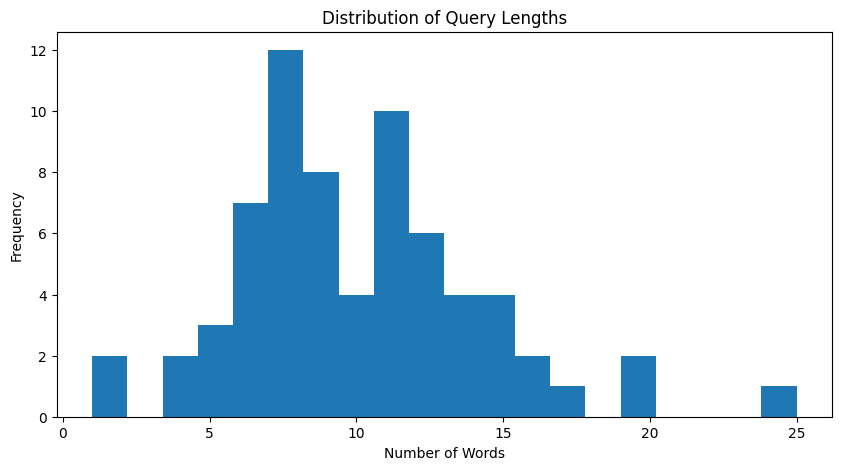

In [20]:
queries_df['query_length'] = queries_df['description'].apply(lambda x: len(x.split()))

print(f"Average query length: {queries_df['query_length'].mean():.2f} words")

plt.figure(figsize=(10, 5))
plt.hist(queries_df['query_length'], bins=20)
plt.title('Distribution of Query Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Query complexity (based on number of entities and noun phrases)
nltk.download('averaged_perceptron_tagger')

def count_noun_phrases(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    return len([tag for tag in pos_tags if tag[1].startswith('NN')])

queries_df['noun_phrase_count'] = queries_df['query'].apply(count_noun_phrases)
queries_df['named_entities'] = queries_df['query'].apply(get_named_entities)
queries_df['entity_count'] = queries_df['named_entities'].apply(lambda x: len([ne for ne in x if isinstance(ne, nltk.Tree)]))

print("Query complexity statistics:")
print(queries_df[['noun_phrase_count', 'entity_count']].describe())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Query complexity statistics:
       noun_phrase_count  entity_count
count           68.00000      68.00000
mean             2.38235       0.00000
std              0.82912       0.00000
min              0.00000       0.00000
25%              2.00000       0.00000
50%              2.00000       0.00000
75%              3.00000       0.00000
max              4.00000       0.00000


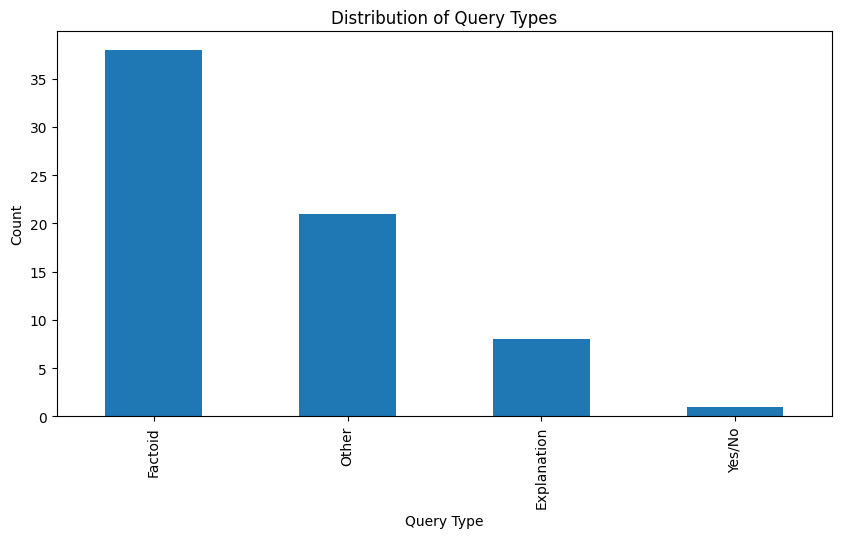

In [21]:
# Query type classification
def classify_query_type(query):
    query = query.lower()
    if query.startswith(('what', 'which', 'who')):
        return 'Factoid'
    elif query.startswith(('how', 'why')):
        return 'Explanation'
    elif query.startswith(('is', 'are', 'does', 'do')):
        return 'Yes/No'
    else:
        return 'Other'

queries_df['query_type'] = queries_df['description'].apply(classify_query_type)
query_type_counts = queries_df['query_type'].value_counts()

plt.figure(figsize=(10, 5))
query_type_counts.plot(kind='bar')
plt.title('Distribution of Query Types')
plt.xlabel('Query Type')
plt.ylabel('Count')
plt.show()

In [27]:
# Word frequency analysis
query_words = [word.lower() for query in queries_df['description'] for word in nltk.word_tokenize(query)]
word_freq = Counter(query_words)

print("\nTop 20 most frequent words in queries:")
print(word_freq.most_common(20))

stopwords_en = stopwords.words('english')
query_words = [word for word in query_words if word not in stopwords_en]
word_freq = Counter(query_words)

print("\nTop 20 most frequent non-stopword words in queries:")
print(word_freq.most_common(20))

punkt = string.punctuation
query_words = [word for word in query_words if word not in punkt]
word_freq = Counter(query_words)

print("\nTop 20 most frequent non-stopword non-punctuation words in queries:")
print(word_freq.most_common(20))


Top 20 most frequent words in queries:
[('?', 48), ('which', 31), ('papers', 26), ('the', 25), ('retrieval', 21), ('of', 20), ('in', 18), ('what', 17), ('and', 17), ('information', 16), ('on', 14), ('how', 13), ('that', 12), ('documents', 12), ('are', 10), ('to', 10), ('about', 9), ('for', 9), ('include', 8), ('algorithms', 7)]

Top 20 most frequent non-stopword words in queries:
[('?', 48), ('papers', 26), ('retrieval', 21), ('information', 16), ('documents', 12), ('include', 8), ('algorithms', 7), ('describe', 6), ('query', 5), ('entries', 5), ('.', 5), ('research', 5), ('focus', 4), ('language', 4), ('processing', 4), ('using', 4), ('search', 4), (',', 4), ('natural', 4), ('(', 4)]

Top 20 most frequent non-stopword non-punctuation words in queries:
[('papers', 26), ('retrieval', 21), ('information', 16), ('documents', 12), ('include', 8), ('algorithms', 7), ('describe', 6), ('query', 5), ('entries', 5), ('research', 5), ('focus', 4), ('language', 4), ('processing', 4), ('using', 4

In [28]:
# Query similarity analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
query_vectors = vectorizer.fit_transform(queries_df['query'])
similarity_matrix = cosine_similarity(query_vectors)

avg_similarity = (similarity_matrix.sum() - similarity_matrix.shape[0]) / (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
print(f"\nAverage cosine similarity between queries: {avg_similarity:.4f}")


Average cosine similarity between queries: 0.0228


#### Vocab statistics

In [32]:
def get_vocabulary(text_series):
    return [word.lower() for text in text_series for word in re.findall(r'\w+', text)]

doc_words = get_vocabulary(docs_df['text'])
doc_vocab = set(doc_words)
query_words = get_vocabulary(queries_df['description'])
query_vocab = set(query_words)

print(f"Document vocabulary size: {len(doc_vocab)}")
print(f"Query vocabulary size: {len(query_vocab)}")
print(f"Vocabulary overlap: {len(doc_vocab.intersection(query_vocab))}")
print(f"Percentage of query vocabulary in document vocabulary: {len(doc_vocab.intersection(query_vocab)) / len(query_vocab) * 100:.2f}%")

Document vocabulary size: 133858
Query vocabulary size: 273
Vocabulary overlap: 273
Percentage of query vocabulary in document vocabulary: 100.00%


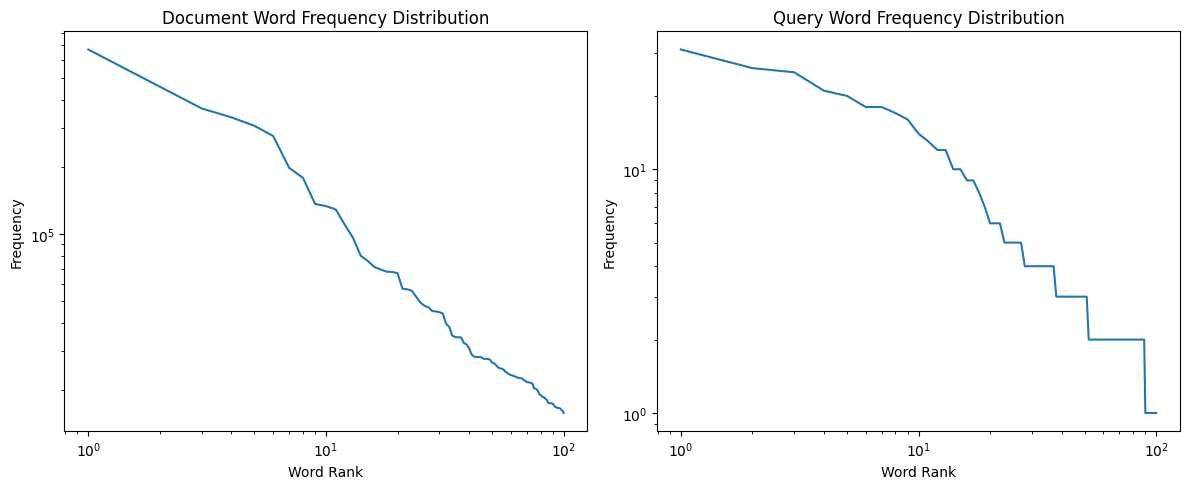

In [33]:
# 2. Word frequency distribution
doc_word_freq = Counter(doc_words)
query_word_freq = Counter(query_words)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.loglog(range(1, 101), [freq for _, freq in doc_word_freq.most_common(100)])
plt.title("Document Word Frequency Distribution")
plt.xlabel("Word Rank")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.loglog(range(1, 101), [freq for _, freq in query_word_freq.most_common(100)])
plt.title("Query Word Frequency Distribution")
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [37]:
# 3. Top words comparison
print("\nTop 20 words in documents:")
print(doc_word_freq.most_common(20))
print("\nTop 20 words in queries:")
print(query_word_freq.most_common(20))


# Without stopwords / punctuation
print("\nTop 20 words in documents (no stopword & punctuation):")
print([(word, frequency) for word, frequency in doc_word_freq.most_common() if word not in stopwords_en and word not in punkt][:20])
print("\nTop 20 words in queries (no stopword & punctuation):")
print([(word, frequency) for word, frequency in query_word_freq.most_common() if word not in stopwords_en and word not in punkt][:20])



Top 20 words in documents:
[('the', 671614), ('of', 457697), ('and', 365591), ('a', 333576), ('to', 305592), ('in', 275086), ('for', 198030), ('we', 178779), ('on', 136473), ('is', 133571), ('that', 128812), ('this', 110098), ('with', 96133), ('as', 80038), ('are', 75806), ('by', 71139), ('an', 69429), ('from', 67887), ('our', 67676), ('based', 66851)]

Top 20 words in queries:
[('which', 31), ('papers', 26), ('the', 25), ('retrieval', 21), ('of', 20), ('in', 18), ('and', 18), ('what', 17), ('information', 16), ('on', 14), ('how', 13), ('that', 12), ('documents', 12), ('are', 10), ('to', 10), ('about', 9), ('for', 9), ('include', 8), ('algorithms', 7), ('does', 6)]

Top 20 words in documents (no stopword & punctuation):
[('based', 66851), ('model', 56871), ('data', 56614), ('language', 55690), ('information', 52234), ('paper', 47714), ('system', 45223), ('task', 45055), ('using', 44702), ('models', 39670), ('results', 38384), ('text', 35082), ('approach', 34558), ('translation', 34503

In [40]:
# 5. TF-IDF analysis
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(docs_df['text'])
feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

print("\nTop 20 words by TF-IDF score:")
for word, score in sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:50]:
    print(f"{word}: {score:.4f}")


Top 20 words by TF-IDF score:
information: 2493.9879
based: 2487.0187
language: 2374.7980
model: 2218.8777
data: 2191.6794
translation: 2087.5814
retrieval: 1963.8316
using: 1897.2675
task: 1893.4045
text: 1754.9613
models: 1720.4906
learning: 1644.3972
word: 1588.3730
approach: 1585.6798
search: 1574.0985
paper: 1541.1706
semantic: 1489.0575
web: 1488.9436
results: 1421.1139
systems: 1374.2751
machine: 1310.3118
method: 1304.8306
evaluation: 1292.6168
analysis: 1290.6577
corpus: 1287.4651
knowledge: 1217.7779
user: 1195.8899
query: 1175.0806
features: 1142.4423
performance: 1140.3989
classification: 1069.7829
different: 1060.8233
document: 1053.5636
use: 1044.2338
methods: 1041.9983
domain: 1037.2524
new: 1019.7561
training: 1003.9633
used: 999.9456
neural: 984.4543
english: 984.2171
speech: 960.0198
social: 956.4911
languages: 951.2110
words: 938.7203
present: 927.2572
large: 914.6342
automatic: 906.5860
tasks: 901.4565
extraction: 894.7462


In [41]:
# 6. Lexical diversity
doc_lexical_diversity = len(doc_vocab) / len(doc_words)
query_lexical_diversity = len(query_vocab) / len(query_words)
print(f"\nDocument lexical diversity: {doc_lexical_diversity:.4f}")
print(f"Query lexical diversity: {query_lexical_diversity:.4f}")


Document lexical diversity: 0.0099
Query lexical diversity: 0.4009


#### Domain-specific info

In [42]:
def get_top_n_words(text_series, n=20):
    words = [word.lower() for text in text_series for word in re.findall(r'\w+', text)]
    return Counter(words).most_common(n)

top_doc_words = get_top_n_words(docs_df['text'])
print("Top 20 words in documents:")
print(top_doc_words)

: 

In [ ]:
# 1. Identify potential domain-specific terms
def extract_potential_domain_terms(text):
    # This regex looks for capitalized words or words with numbers
    return re.findall(r'\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*|\w+\d+\w*|\w+\-\w+)\b', text)

doc_domain_terms = [term for doc in docs_df['text'] for term in extract_potential_domain_terms(doc)]
query_domain_terms = [term for query in queries_df['query'] for term in extract_potential_domain_terms(query)]

print("Top 20 potential domain-specific terms in documents:")
print(Counter(doc_domain_terms).most_common(20))
print("\nTop 20 potential domain-specific terms in queries:")
print(Counter(query_domain_terms).most_common(20))

In [ ]:
# 2. Word cloud of domain-specific terms
domain_text = ' '.join(doc_domain_terms)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(domain_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Potential Domain-Specific Terms')
plt.show()

In [ ]:
# 3. Analyze n-grams
def get_ngrams(text, n):
    words = nltk.word_tokenize(text.lower())
    return list(nltk.ngrams(words, n))

doc_bigrams = [bigram for doc in docs_df['text'] for bigram in get_ngrams(doc, 2)]
doc_trigrams = [trigram for doc in docs_df['text'] for trigram in get_ngrams(doc, 3)]

print("\nTop 20 bigrams in documents:")
print(Counter(doc_bigrams).most_common(20))
print("\nTop 20 trigrams in documents:")
print(Counter(doc_trigrams).most_common(20))

In [ ]:
# 4. Analyze document structure
docs_df['title_length'] = docs_df['text'].apply(lambda x: len(x.split('\n\n')[0].split()))
docs_df['has_abstract'] = docs_df['text'].apply(lambda x: len(x.split('\n\n')) > 1)

print(f"\nAverage title length: {docs_df['title_length'].mean():.2f} words")
print(f"Percentage of documents with abstract: {docs_df['has_abstract'].mean()*100:.2f}%")

In [ ]:
# 5. Identify common abbreviations
def extract_abbreviations(text):
    return re.findall(r'\b[A-Z]{2,}\b', text)

doc_abbrevs = [abbr for doc in docs_df['text'] for abbr in extract_abbreviations(doc)]
query_abbrevs = [abbr for query in queries_df['query'] for abbr in extract_abbreviations(query)]

print("\nTop 20 abbreviations in documents:")
print(Counter(doc_abbrevs).most_common(20))
print("\nTop 20 abbreviations in queries:")
print(Counter(query_abbrevs).most_common(20))

In [ ]:
# 6. Analyze query types
def classify_query(query):
    query = query.lower()
    if any(query.startswith(word) for word in ['what', 'who', 'when', 'where', 'which']):
        return 'Factoid'
    elif query.startswith('how'):
        return 'Procedure'
    elif query.startswith('why'):
        return 'Explanation'
    elif any(word in query for word in ['difference', 'compare', 'versus', 'vs']):
        return 'Comparison'
    else:
        return 'Other'

queries_df['query_type'] = queries_df['query'].apply(classify_query)
query_type_dist = queries_df['query_type'].value_counts(normalize=True)

print("\nQuery type distribution:")
print(query_type_dist)

plt.figure(figsize=(10, 5))
query_type_dist.plot(kind='bar')
plt.title('Distribution of Query Types')
plt.xlabel('Query Type')
plt.ylabel('Proportion')
plt.show()

#### Qrels statistics

In [ ]:
qrels_df['relevant'] = qrels_df['qrel'] > 0
relevant_per_query = qrels_df.groupby('qid')['relevant'].sum()

print(f"Average number of relevant documents per query: {relevant_per_query.mean():.2f}")

plt.figure(figsize=(10, 5))
plt.hist(relevant_per_query, bins=20)
plt.title('Distribution of Relevant Documents per Query')
plt.xlabel('Number of Relevant Documents')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 1. Distribution of relevance scores
plt.figure(figsize=(10, 5))
plt.hist(qrels_df['qrel'], bins=np.arange(qrels_df['qrel'].min(), qrels_df['qrel'].max()+2)-0.5)
plt.title('Distribution of Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 2. Queries with most/least relevant documents
relevant_docs_per_query = qrels_df[qrels_df['qrel'] > 0].groupby('qid').size().sort_values(ascending=False)
print("Queries with most relevant documents:")
print(relevant_docs_per_query.head())
print("\nQueries with least relevant documents:")
print(relevant_docs_per_query.tail())

In [ ]:
# 3. Correlation between query length and number of relevant documents
query_lengths = queries_df.set_index('qid')['query'].apply(lambda x: len(x.split()))
correlation = query_lengths.corr(relevant_docs_per_query)
print(f"\nCorrelation between query length and number of relevant documents: {correlation:.4f}")

In [ ]:
# 4. Percentage of queries with at least one relevant document
queries_with_relevant = (relevant_docs_per_query > 0).mean() * 100
print(f"\nPercentage of queries with at least one relevant document: {queries_with_relevant:.2f}%")

In [ ]:
# 5. Average relevance score
avg_relevance = qrels_df['qrel'].mean()
print(f"\nAverage relevance score: {avg_relevance:.4f}")

#### Data qualitiy? -> zu vocab

In [ ]:
non_english = docs_df['text'].apply(lambda x: not x.isascii()).sum()
print(f"Number of potentially non-English documents: {non_english}")

duplicate_docs = docs_df['text'].duplicated().sum()
print(f"Number of duplicate documents: {duplicate_docs}")

#### BERT-specific analisis

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def get_token_length(text):
    return len(tokenizer.encode(text))

docs_df['token_length'] = docs_df['text'].apply(get_token_length)
queries_df['token_length'] = queries_df['query'].apply(get_token_length)

print(f"Max document token length: {docs_df['token_length'].max()}")
print(f"Max query token length: {queries_df['token_length'].max()}")

plt.figure(figsize=(10, 5))
plt.hist(docs_df['token_length'], bins=50)
plt.title('Distribution of Document Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Out-of-vocabulary statistics -> how many unknown words?
def get_oov_words(text):
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token.startswith('##')]

docs_df['oov_words'] = docs_df['text'].apply(get_oov_words)
queries_df['oov_words'] = queries_df['query'].apply(get_oov_words)

print(f"Average OOV words per document: {docs_df['oov_words'].apply(len).mean():.2f}")
print(f"Average OOV words per query: {queries_df['oov_words'].apply(len).mean():.2f}")

#### OLD

In [29]:
def analyze_text(texts):
    #char_counts = Counter()
    #word_counts = Counter()
    #number_counts = Counter()
    #special_char_counts = Counter()
    abbreviation_counts = Counter()
    words_with_numbers = Counter()

    #abbreviation_regex = r'\b(?:[A-Za-z]\.){2,}'
    abbreviation_regex = r'\b(?:[A-Za-z]\.?){2,}\.'
    number_in_word_regex = r'\b\w*\d+\w*\b' #r'\w*\d\w*' 

    for text in texts:
        # Zählen der Zeichen
        #char_counts.update(text)
        # Tokenisierung
        #tokens = word_tokenize(text)
        #word_counts.update(tokens)
        # Zählen von Zahlen
        #numbers = re.findall(r'\b\d+\b', text)
        #number_counts.update(numbers)
        # Zählen von Abkürzungen
        abbreviations = re.findall(abbreviation_regex, text)
        abbreviation_counts.update(abbreviations)
        # Zählen von Sonderzeichen
        #special_char_counts.update(re.findall(r'[^\w\s]', text))
        # Finden von Wörtern, die Zahlen enthalten
        words_with_number = re.findall(number_in_word_regex, text)
        words_with_numbers.update(words_with_number)

    # Ausgabe der gesammelten Statistiken
    #print(f"Anzahl der Zeichen: {sum(char_counts.values())}")
    #print(f"Anzahl der Wörter: {sum(word_counts.values())}")
    #print(f"Am häufigsten vorkommende Wörter: {word_counts.most_common(10)}")
    #print(f"Am häufigsten vorkommende Zahlen: {number_counts.most_common(10)}")
    #print(f"Am häufigsten vorkommende Sonderzeichen: {special_char_counts.most_common(10)}")
    print(f"Am häufigsten vorkommende Abkürzungen: {abbreviation_counts.most_common(200)}")
    print(f"Wörter mit Zahlen: {words_with_numbers.most_common(200)}")




In [2]:
analyze_text(texts)

NameError: name 'analyze_text' is not defined